# Overview

Create a simple baseline model to compare more advanced methods against.

### Ideas based on EDA

**Categorical variables as primary predictors:**
- Take one or a combination of variables and calculate the average salary per category

Predicting salaries on new data will involve using stored fitted values that were calculated on training data. The fitted values for categorical variables will simply be the grouped averages. Later the new data will have these averages joined to it, by using the group of categorical variables as the key.


**Numerical variables as additive predictors:**

The baseline model will require at least one categorical variable. Models using just a numerical variable for prediction will not be tested here. To illustrate why this decision was made, consider taking the average salary of all jobs within 1 `milesFromMetropolis`, for example. This will include a mixture of all different levels of `jobTypes` and will likely not give a good estimate. Because the average value would be taking into account roles ranging from `JANITOR` to `CEO`.

Instead, the way the these numerical variables will be factored into the predictions is by looking at how different the grouped averages are from the overall average. The salary that is predicted by the categorical variable is shifted based on this difference. Hopefully this will help the baseline model better distinguish between varying levels of experience for the same job category.

There is a manageable number of unique values that either `yearsExperience` or `milesFromMetropolis` can take on, but this approach would not be scalable to a wide range of continuous values (at least without some discretization).

___

_For example_

- We know from EDA that:
    - 116k - Avg. salary overall
    -  92k  - Avg. salary salary for jobs with 0 `yearsExperience` - _(24k lower than overall average)_
    - 140k - Avg. salary salary for jobs with 24 `yearsExperience` - _(24k higher than overall average)_  

- When predicting the salary for a `jobType` of `MANAGER` with 0 `yearsExperience`:
    1. 115k starting point - the grouped categorical average for managers, in this case
    2. We can expect the prediction to be 24k lower than the average `MANAGER`'s salary 
    3. The final salary prediction is then 91k  
        a. conversely, a manager with 24 `yearsExperience` will have the expected salary bumped up by 24k to 139k
        

___

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

from src.Baseline import BaselineModel, SelectBestModel
from src.baseline_utils import visualize_numeric_fit

# Load data

In [2]:
train_salaries = pd.read_csv("../data/interim/salaries_train_85_15_split.csv", index_col = 0)
test_salaries = pd.read_csv("../data/interim/salaries_test_85_15_split.csv", index_col = 0)

print(f"training set shape: {train_salaries.shape}")
print(f"test set shape: {test_salaries.shape}")

training set shape: (849995, 8)
test set shape: (150000, 8)


# Example baseline model to illustrate functionality

## Fitting the model

The model is instantiated with `BaselineModel()` and is fit using the `.fit()` method, passing in a dataframe.

- args:
    + _category_vars_ (required): String or list of strings of categorical variables
    + _numeric_vars_ (optional): String or list of strings of numerical variables
    + _id_var_ (optional): Name of the ID column - set to 'jobId' by default
    + _target_ (optional): Name of the target variable - set to 'salary' by default 

In [3]:
example_baseline = BaselineModel(category_vars='jobType', numeric_vars=['yearsExperience', 'milesFromMetropolis'])
example_baseline.fit(train_salaries)

#### Fitted categorical values

- Stored as a dataframe with one column: `salary_preds`  
- The index is the grouping variable used for calculating the average salary
    + For multiple categorical variables the index will be multi-leveled

In [4]:
example_baseline.fitted_category_salaries

,salary_preds
jobType,
JANITOR,70.785181
JUNIOR,95.341564
SENIOR,105.405757
MANAGER,115.419110
VICE_PRESIDENT,125.390156
CFO,135.441672
CTO,135.485534
CEO,145.364115


#### Fitted numerical values

- Stored as a dictionary with a key for each numerical column that was used for fitting  
- The value of each key contains a Series that represents, for each unique value, the difference between the average salary of that value and the overall average salary 

In [5]:
example_baseline.fitted_numeric_diffs

{'yearsExperience': yearsExperience
 0    -24.173570
 1    -22.052242
 2    -19.969124
 3    -18.064561
 4    -16.023098
 5    -14.395663
 6    -12.127425
 7     -9.997218
 8     -8.301810
 9     -5.921390
 10    -3.938727
 11    -2.166129
 12     0.444267
 13     1.857557
 14     4.233491
 15     5.923825
 16     8.032665
 17     9.979064
 18    12.310572
 19    13.831090
 20    16.160942
 21    18.112413
 22    20.266673
 23    22.328628
 24    24.114106
 Name: yearsExperience_diff, dtype: float64,
 'milesFromMetropolis': milesFromMetropolis
 0     19.276701
 1     19.659869
 2     19.054796
 3     18.436109
 4     18.819768
         ...    
 95   -18.044574
 96   -18.752739
 97   -18.601879
 98   -18.841883
 99   -20.292592
 Name: milesFromMetropolis_diff, Length: 100, dtype: float64}

##### Visualizing the numeric fitted values

The two charts below show the behavior of the model, with respect to each of the numeric variables. 

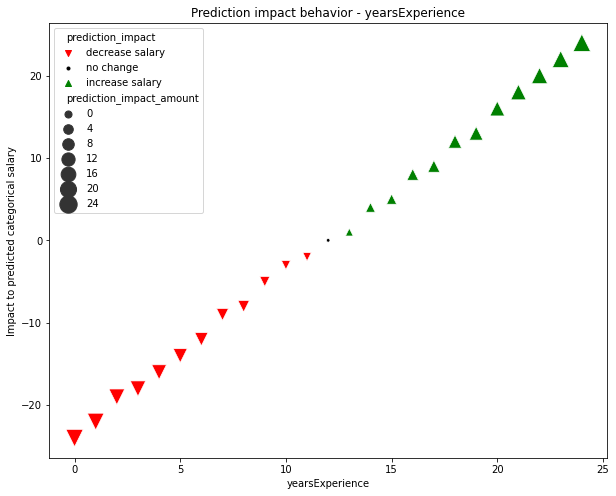

In [6]:
visualize_numeric_fit(example_baseline.fitted_numeric_diffs['yearsExperience'])

Values close to 12 `yearsExperience` will have little to no impact on the final salary amount. Values close to 0 or 24 will decrease or increase the predicted salary amount by the most, respectively.

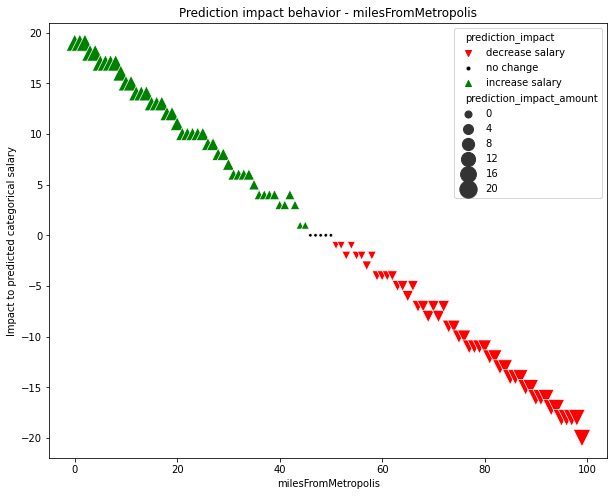

In [7]:
visualize_numeric_fit(example_baseline.fitted_numeric_diffs['milesFromMetropolis'])

Values close to 50 `milesFromMetropolis` will have little to no impact on final salary amount. Values close to 0 or 100 will increase or decrease the predicted salary by the most, respectively.

## Final prediction process

Predicting on new data is done with the `.predict()` method, passing in a dataframe 

In [8]:
# Return all columns to get the intermediary variables that were created when including the numeric variables for prediction
example_preds = example_baseline.predict(test_salaries, return_all_cols = True)

Take a look at the resulting predictions and some of the columns that were created under the hood to help with calculations.

**Definitions of important intermediary columns**

New columns get added to the dataset, to help with numeric prediction calculations - some notable ones are:
- **category_preds**: Predictions from the `fitted_category_salaries` attribute. It is mainly used for diagnostics and checking the influence of numeric variables
- **yearsExperience_diff** & **milesFromMetropolis_diff**: The joined values from the `fitted_numeric_diffs` attribute, used to add to the `category_preds`
- **combined_diff**: The combination of the two '_diff' columns, either added together or averaged
- **final_preds**: Salary prediction after row-wise summing `category_preds` and `combined_diff` columns

In [9]:
interesting_cols = ['jobType', 'yearsExperience', 'milesFromMetropolis',
                    'yearsExperience_diff', 'milesFromMetropolis_diff',
                    'category_preds_tmp', 'sum_numeric_diff', 'preds_with_sum', 'salary']
example_preds = example_preds[interesting_cols]

# Rename some columns for easier readability
col_rename = {
    'sum_numeric_diff': 'combined_diff',
    'category_preds_tmp': 'category_preds',
    'preds_with_sum': 'final_preds',
    'salary': 'salary_actual'
}
example_preds.rename(columns = col_rename, inplace = True)

# Inspect some random examples
example_preds.sample(5, random_state = 50)

,jobType,yearsExperience,milesFromMetropolis,yearsExperience_diff,milesFromMetropolis_diff,category_preds,combined_diff,final_preds,salary_actual
443822,JANITOR,3,15,-18.064561,13.599846,70.785181,-4.464715,66.320466,78
417907,CEO,17,50,9.979064,-0.567644,145.364115,9.411420,154.775536,206
165074,CTO,6,68,-12.127425,-7.143497,135.485534,-19.270922,116.214612,126
617693,MANAGER,13,89,1.857557,-15.506759,115.419110,-13.649202,101.769908,73
338229,JUNIOR,4,32,-16.023098,6.610019,95.341564,-9.413079,85.928484,101


From this sample, we can see that the influence of the numeric variables is helpful in some cases, but not in others where the final prediction is farther away from the actual salary than the grouped average.

**Interpreting the predictions:**

Looking at the `CEO` job in this case:  
1. Starting at the grouped average of about 145k
2. 17 `yearsExperience` adds about 10k
3. 50 `milesFromMetropolis` wont change the prediction much (about -0.5k)
4. The overall influence of the numeric variables is to increase the grouped average by ~9.4k
5. Final prediction: `category_preds` + ~9.4k = ~155k
    - The resulting prediction is closer to the actual salary than just the grouped average from `category_preds`

**Couple of thoughts to keep in mind when using this baseline model:**
1. Double check the errors when numerical variables are used in the prediction.  
- The `JANITOR` job in this case had a better predicted salary when only using the grouped average.
- Need to see how often the numeric variables can be wildly unhelpful.
   - Idea for a metric: How often is the error for predictions, with numeric variables included, larger than just using the categorical grouped average?

2. Test 2 methods of combining the numeric diff columns: `sum` & `mean`.  
Averaging the numeric diff columns could help mitigate extreme edge cases.

    - It looks possible for the numeric variables to potentially have a huge influence on the final prediction.
    - If a job has 0 `yearsExperience` and is 99 `milesFromMetropolis` then the combined diff is about -40k
        - or  it could be +40k for values of 25 `yearsExperience` and 0 `milesFromMetropolis`.
        
> _Specific possibility of edge case:_
> - We know from EDA that one of the lower-end salaries for `JANITOR` jobs is in the `EDUCATION` industry
>     - About 55k - the average salary when grouped by these two variables
> - If there is such an example where the model reduces categorical average by upwards of 40k, then the predicted salary gets unreasonably small
>     - **Are there cases, in the test set, that this kind of model could even predict a negative salary??**
> - This kind of behavior seems a little extreme

# Find the best baseline model parameters

Test all combinations of the 4 categorical variables that are in the data set. And for each combination evaluate different variations of using the numeric variables or not.

#### All combinations of categorical variables

In [10]:
category_vars = ['jobType', 'degree', 'major', 'industry']

category_combos = []
for i in range(1,5):
    combos = combinations(category_vars, i)
    for j in combos:
        category_combos.append(list(j))

print(f"There are {len(category_combos)} combinations of categorical variables")
category_combos

There are 15 combinations of categorical variables


[['jobType'],
 ['degree'],
 ['major'],
 ['industry'],
 ['jobType', 'degree'],
 ['jobType', 'major'],
 ['jobType', 'industry'],
 ['degree', 'major'],
 ['degree', 'industry'],
 ['major', 'industry'],
 ['jobType', 'degree', 'major'],
 ['jobType', 'degree', 'industry'],
 ['jobType', 'major', 'industry'],
 ['degree', 'major', 'industry'],
 ['jobType', 'degree', 'major', 'industry']]

The values of the `model_variations` dictionary get passed to `BaselineModel()`. Each combination of categorical variables will therefore have 5 variations evaluated, totaling 75 different tests.

The variations:
- **only_categorical**: No numeric variables used for fitting, predictions will be made only with grouped categorical averages
- **add_yearsExperience**: The `yearsExperience` variable is used for fitting and added to the categorical average
- **add_milesFromMetropolis**: The `milesFromMetropolis` variable is used for fitting and added to the categorical average
- **add_both**: Both of the above numeric variables are used and the relative differences are combined and added to the categorical average
    + there are two models created for this variation. One combining the numeric fitted values using `sum`, and the other using `mean`

Best model score: 371.221955706675

Best model parameters:
{'category_vars': ['jobType', 'degree', 'major', 'industry'], 'numeric_vars': ['yearsExperience', 'milesFromMetropolis'], 'numeric_combo': 'sum'}





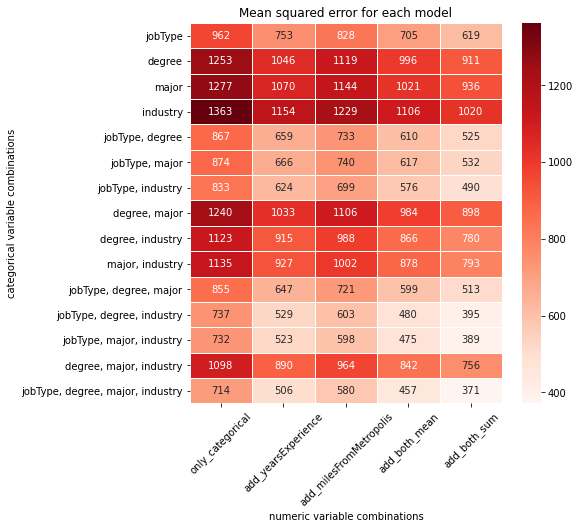

In [11]:
model_variations = {
    'only_categorical': None,
    'add_yearsExperience': 'yearsExperience',
    'add_milesFromMetropolis': 'milesFromMetropolis',
    'add_both': ['yearsExperience', 'milesFromMetropolis']
}
best_model = SelectBestModel(train_salaries, test_salaries, category_combos, model_variations)

#### Insights from testing 75 variations

- **Both numeric variables:**
    - Using `sum` to combine the numeric diffs gives lower MSE than using `mean` - *in every instance*
- **1 numeric variable:**
    - Using `yearsExperience` gives a lower MSE than `milesFromMetropolis` - *in every instance*
- **2 or 3 categorical variables:**
    - When `jobType` is __not__ a part of the categorical variables, the MSE is much higher than when it is included

In [12]:
# Make a couple functions here for getting residuals, and describing residuals

def get_residuals(data: pd.DataFrame, add_to_df = False) -> pd.DataFrame:
    """Given a dataframe of baseline predictions, return a dataframe with residual columns added
    
    Must set return_all_cols=True when predicting with BaselineModel().predict
    """
    # required columns for this to work: 'salary_preds' , 'category_preds_tmp'
    required_cols = ['jobId', 'salary', 'salary_preds', 'category_preds_tmp']
    # If there are any required columns missing, raise error
    if [i for i in required_cols if i not in data.columns]:
        raise ValueError(f'Prediction columns seem to be missing. Be sure to set "return_all_cols" when predicting from BaselineModel()')
        
    data['final_residuals'] = data.salary - data.salary_preds
    data['category_residuals'] = data.salary - data.category_preds_tmp
    
    # Use the absolute value to compare the magnitude of residual values
    data['final_error_higher'] = data.final_residuals.abs() > data.category_residuals.abs()
    
    if not add_to_df:
        data = data.loc[:, required_cols + ['final_residuals', 'category_residuals', 'final_error_higher']]
    
    return data

#### Inspect the errors of the model

The variation of baseline with the lowest MSE incorporates numerical variables so we should make sure there aren't many cases of the numeric variables being wildly unhelpful.

**Analysis:**
1. Distribution of residuals
2. Did the best model end up predicting any negative salaries on the test set?
3. How often is the influence from the numeric variables unhelpful?
    1. Metric: *unhelpful percent* - Frequency of `salary_preds` variable having higher error than `category_preds_tmp`
        - `mean( abs(final_residuals) > abs(category_residuals) )`
    2. Is there a pattern to which variables cause the worst cases of unhelpful influence?

In [31]:
# Test set predictions
best_baseline = best_model.best_model
best_preds = best_baseline.predict(test_salaries, numeric_combo = "sum", return_all_cols = True)
best_preds.head()

,jobId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary,salary_preds,yearsExperience_diff,milesFromMetropolis_diff,sum_numeric_diff,mean_numeric_diff,preds_with_sum,preds_with_mean,category_preds_tmp
58414,JOB1362684466101,JUNIOR,HIGH_SCHOOL,NONE,WEB,14,84,80,81.156102,4.233491,-13.637052,-9.403561,-4.701780,81.156102,85.857882,90.559663
902618,JOB1362685310305,SENIOR,MASTERS,COMPSCI,SERVICE,24,86,124,116.536360,24.114106,-14.998958,9.115148,4.557574,116.536360,111.978786,107.421212
778824,JOB1362685186511,JANITOR,NONE,NONE,WEB,4,86,54,44.189400,-16.023098,-14.998958,-31.022056,-15.511028,44.189400,59.700429,75.211457
187593,JOB1362684595280,SENIOR,HIGH_SCHOOL,NONE,WEB,0,42,80,80.366331,-24.173570,4.000113,-20.173456,-10.086728,80.366331,90.453060,100.539788
574438,JOB1362684982125,VICE_PRESIDENT,MASTERS,BUSINESS,AUTO,16,97,89,115.844579,8.032665,-18.601879,-10.569214,-5.284607,115.844579,121.129186,126.413793


In [14]:
# Get residual information
best_mdl_residuals = get_residuals(best_preds)
best_mdl_residuals.head()

,jobId,salary,salary_preds,category_preds_tmp,final_residuals,category_residuals,final_error_higher
58414,JOB1362684466101,80,81.156102,90.559663,-1.156102,-10.559663,False
902618,JOB1362685310305,124,116.536360,107.421212,7.463640,16.578788,False
778824,JOB1362685186511,54,44.189400,75.211457,9.810600,-21.211457,False
187593,JOB1362684595280,80,80.366331,100.539788,-0.366331,-20.539788,False
574438,JOB1362684982125,89,115.844579,126.413793,-26.844579,-37.413793,False


Residual info
--------------------
Summary Stats:
count    150000.000000
mean         -0.024095
std          19.267170
min         -65.616577
25%         -14.037699
50%          -0.410280
75%          13.216444
max          81.857500
Name: final_residuals, dtype: float64



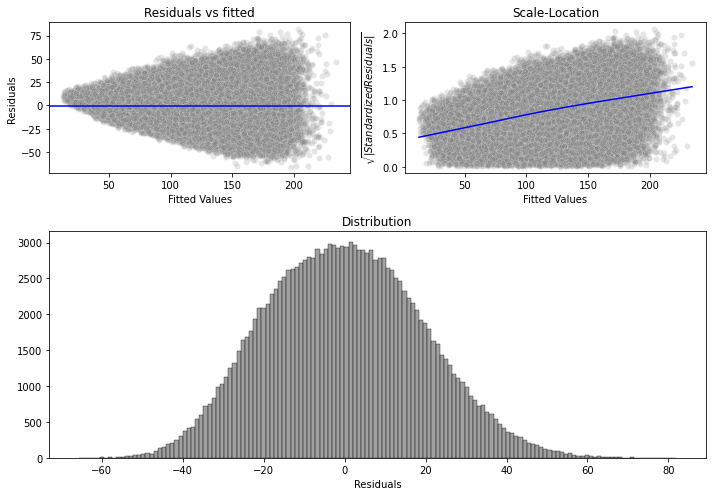

In [134]:
def describe_residuals(resids: pd.DataFrame):
    """Prints out and reports summary statistics on the residuals.
    
    Meant to work with the output of 'get_residuals()' function
    """
    print("Residual info")
    print("-"*20)
    
    print("Summary Stats:")
    print(resids.final_residuals.describe(), end = '\n\n')
    
    # Setup figure and grid
    fig, ax = plt.subplots(2,2, figsize=(10, 7), gridspec_kw = {'height_ratios': [2,3]})
    grid_shape = (2,2)
    resid_v_fitted = plt.subplot2grid(grid_shape, (0,0))
    scale_location = plt.subplot2grid(grid_shape, (0,1))
    resid_distn = plt.subplot2grid(grid_shape, (1,0), colspan = 2)
    
    # Residuals vs fitted
    sns.scatterplot(x = 'salary_preds', y = 'final_residuals', data = resids, alpha = 0.2, color = 'grey', ax = resid_v_fitted)
    resid_v_fitted.axhline(resids.final_residuals.mean(), color = 'blue')
    resid_v_fitted.set_xlabel('Fitted Values')
    resid_v_fitted.set_ylabel('Residuals')
    resid_v_fitted.set_title('Residuals vs fitted')
    
    # Scale-Location
    std_resids = resids.final_residuals / resids.final_residuals.std()
    std_resids = np.sqrt(std_resids.abs())
    delta = 0.00005 * len(resids) # For computational efficiency, with lowess, on large data 
    loess = lowess(std_resids, resids.salary_preds, it = 0, delta = delta, return_sorted = False)
    
    sns.scatterplot(x = resids.salary_preds, y = std_resids, alpha = 0.2, color = 'grey', ax = scale_location)
    sns.lineplot(x = resids.salary_preds, y = loess, ci = None, color = "blue", ax = scale_location)
    
    scale_location.set_ylabel('$\sqrt{|Standardized Residuals|}$')
    scale_location.set_xlabel('Fitted Values')
    scale_location.set_title('Scale-Location')
    
    # Residual distribution
    sns.histplot(x = 'final_residuals', data = resids, ax = resid_distn, color = 'grey')
    resid_distn.set_title('Distribution')
    resid_distn.set_ylabel('')
    resid_distn.set_xlabel('Residuals')
    
    plt.tight_layout()
    plt.show()
    
describe_residuals(best_mdl_residuals)

Distribution of residuals


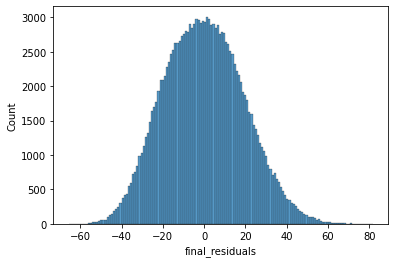

count    150000.000000
mean         -0.024095
std          19.267170
min         -65.616577
25%         -14.037699
50%          -0.410280
75%          13.216444
max          81.857500
Name: final_residuals, dtype: float64

In [15]:
print("Distribution of residuals")
sns.histplot(x = 'final_residuals', data = best_mdl_residuals)
plt.show()
best_mdl_residuals.final_residuals.describe()

#### Any negative salaries predicted?

In [16]:
best_preds.salary_preds.describe()

count    150000.000000
mean        116.109048
std          33.557776
min          12.828829
25%          92.965122
50%         117.249951
75%         139.878201
max         234.210345
Name: salary_preds, dtype: float64

No negative salaries predicted. However, the least salary predicted was ~13k which could align with the edge case hypothesized above. (i.e. Salaries being predicted unreasonably low due to the influence of the numeric variables).

Should check and see if these are cases of unhelpful influence from the numeric variables

In [17]:
best_preds.loc[best_preds.salary_preds.astype(int).isin([12,13]), ['salary_preds', 'salary', 'category_preds_tmp', 'final_error_higher', 'category_residuals', 'final_residuals']]

,salary_preds,salary,category_preds_tmp,final_error_higher,category_residuals,final_residuals
143597,13.728080,24,55.046973,False,-31.046973,10.271920
145729,12.828829,22,55.046973,False,-33.046973,9.171171
626155,13.126755,24,55.471588,False,-31.471588,10.873245
74501,13.253444,23,55.471588,False,-32.471588,9.746556
940378,13.572571,20,55.046973,False,-35.046973,6.427429
999915,13.997186,29,55.471588,False,-26.471588,15.002814


These cases of low prediction amounts actually **don't** align with the edge case I hypothesized. Without the numeric variables the model would be off by upwards of 30k. The influence of the numeric variables overshoot the actual values and end up under predicting the salary, but the error is still lower than just using the categorical predictions.

#### Frequency of unhelpful influence of numeric variables

Frequency of unhelpful numeric variable influence: 36.07%



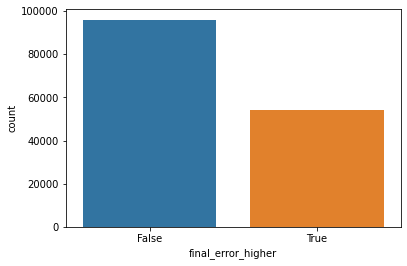

In [18]:
unhelpful_percent = round(best_mdl_residuals.final_error_higher.mean() * 100, 2)
print(f"Frequency of unhelpful numeric variable influence: {unhelpful_percent}%\n")
sns.countplot(x = 'final_error_higher', data = best_mdl_residuals)
plt.show()

Queue the sad trombone sound, because that's a somewhat worrisome frequency. Most of the time the numeric variables are helpful, but more than a third of the time the prediction is farther away from the actual value than just using the categorical average.
- If there is a pattern to which jobs the numeric variables behave poorly for, this could indicate an area for improving the baseline. It also means that there are whole subgroups of similar jobs for which the model will reliably predict poorly on, if it is not improved.

#### Check for a pattern to unhelpful influence

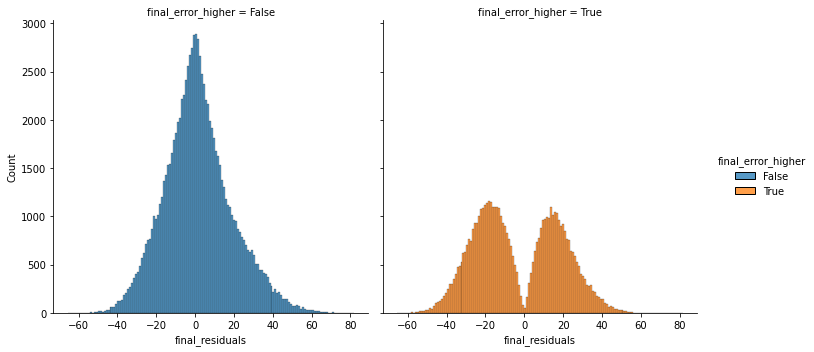

In [19]:
sns.displot(x = 'final_residuals', col='final_error_higher', data = best_mdl_residuals, kind = 'hist', hue = 'final_error_higher')
plt.show()

fitted values vs residuals

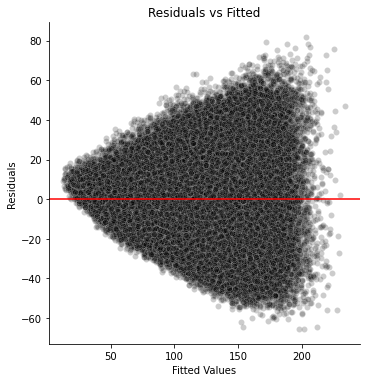

In [29]:
sns.relplot(x = 'salary_preds', y = 'final_residuals', data = best_mdl_residuals, alpha = 0.2, color = 'black')
plt.axhline(y = best_mdl_residuals.final_residuals.mean(), color = 'red')
plt.title('Residuals vs Fitted')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

@@@ --- It looks like when the model is predicting 50 or less,

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylabel'

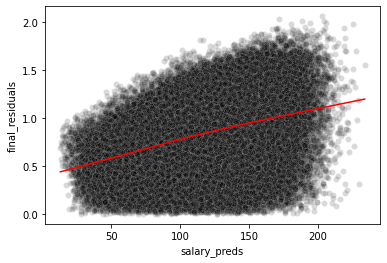

In [88]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

def scale_location(resids, fitted_values, ax = None):
    standardized = resids / resids.std()
    standardized = np.sqrt(standardized.abs())
    delta = 0.00005 * len(fitted_values) # For computational efficiency with large data
    loess = lowess(standardized, fitted_values, it = 0, delta = delta, return_sorted = False)
    
    sns.scatterplot(x = fitted_values, y = standardized, alpha = 0.15, color = 'black', ax = ax)
    sns.lineplot(x = fitted_values, y = loess, ci = None, color = "red", ax = ax)
    
    if not ax:
        ax = plt
    
    ax.set_ylabel('$\sqrt{|Standardized Residuals|}$')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Scale-Location')

    if not ax:
        plt.show()
scale_location(best_mdl_residuals.final_residuals, best_mdl_residuals.salary_preds)

In [25]:
# Get standard error of the residuals when the model predicts 50k or 175k
for i in [50, 175]:
    std_error = best_mdl_residuals.final_residuals.loc[best_mdl_residuals.salary_preds.astype(int) == i].std()
    print(f"Std error of residuals when predicting {i}: {round(std_error, 2)}")

Std error of residuals when predicting 50: 8.63
Std error of residuals when predicting 175: 28.34


The standard error of the residuals grows as the model predicts higher salaries. When predicting 175 the standard error of the residuals is much higher than when predicting 50.

**Is there a distinct grouping of variables that have a large amount of unhelpful influence?**

Next areas to investigate for best baseline before comparing some other options
- Differences between jobs that have higher error than lower error?
    - just using the residual/abs(residual) value and partitioning groups
- Differences between jobs that have large amount of negative influence vs small?
    - of the unhelpful examples, look at differences between large and small magnitudes

TODO: compare other models:
- are there other models that have a slightly higher overall MSE but more stable predictions?